In [3]:
import pandas as pd
import plotly.express as px
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Loading dataset
data_path = 'dataset/tiktok_google_play_reviews.csv'
data = pd.read_csv(data_path)

In [3]:
data.head()
# print(data.head().to_markdown(index = False))

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHRz-11c0apHLSKHHp52FxUXsQS9Z88wP3sWc5...,MR LOL GAMER,https://play-lh.googleusercontent.com/a/AATXAJ...,Good,5,0,23.8.4,2022-04-05 23:18:30,NaN,NaN
1,gp:AOqpTOF6mFDEkIypmyT3shDLjPHg8zB3kdns2W36ahp...,Dino Kljako,https://play-lh.googleusercontent.com/a-/AOh14...,Awesome app! Too many people on it where it's ...,5,0,NaN,2022-04-05 23:18:21,NaN,NaN
2,gp:AOqpTOGtqU4sb8vuVo3-eB7kIXWoBn-0YCUZ1SnPRKS...,Olivia Harding,https://play-lh.googleusercontent.com/a/AATXAJ...,Not bad,5,0,23.9.5,2022-04-05 23:17:34,NaN,NaN
3,gp:AOqpTOFHDm-Qa5R6jCpOGTFT2qr1_PKbCTbBNPahCEn...,Keli We,https://play-lh.googleusercontent.com/a-/AOh14...,It is good,2,0,22.2.5,2022-04-05 23:17:04,NaN,NaN
4,gp:AOqpTOFB6Ndao8IHRpOJRmbSknwMGxHcwYzux93YyXI...,Mavis Kotoka,https://play-lh.googleusercontent.com/a/AATXAJ...,Very interesting app,5,0,22.1.5,2022-04-05 23:17:04,NaN,NaN


In [4]:
print("The dataset contains {} observations and {} features".format(data.shape[0], data.shape[1]))
print("The features are :  {} ".format(', '.join(data.columns)))

The dataset contains 307057 observations and 10 features
The features are :  reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt 


The dataset contains, 10 columns with different values some of which we would not use since we
are analyzing the reviews on TikTok, the two crucials tables here would be be _"score"_ and 
_"content"_. Thus we can build a new dataset with those columns.

In [5]:
data = data[['content','score']]
print(data.head(5))

                                             content  score
0                                               Good      5
1  Awesome app! Too many people on it where it's ...      5
2                                            Not bad      5
3                                         It is good      2
4                               Very interesting app      5


In [6]:
df_groupby_score = data.groupby(['score'])
# df_groupby_score.ngroups
# df_groupby_score.groups
# df_groupby_score.size()
df_groupby_score.describe().head()

content                    
        count  unique   top  freq
score                            
1       37079   30920  Nice   633
2        7833    7074  Good   144
3       11652    9990  Good   320
4       17985   14158  Good   715
5      232504  133483  Good  9657

This gives us an insight into the __score__ distribution value, we can observe the __count, unique and frequency__ associated with each value.

In [7]:
# check for null value and drop any 
print('Before droping null values: \n',data.isnull().sum())
data = data.dropna()
print('After droping null values: \n',data.isnull().sum())

Before droping null values: 
 content    4
score      0
dtype: int64
After droping null values: 
 content    0
score      0
dtype: int64


In [8]:
# Data cleaning
stopword = set(stopwords.words("english"))
stemmer = nltk.SnowballStemmer("english")
# print(stopword)
def preprocess(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text
data['content'] = data['content'].apply(preprocess)
# print(data['content'])

C:\Users\arman\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
ratings = data['score'].value_counts()
index = ratings.index
fig = px.pie(data, values=ratings, names=index, hole = 0.5)
fig.update_layout(title = 'Ratings distribution', title_x=0.5, height= 500, width = 800)
fig.show()

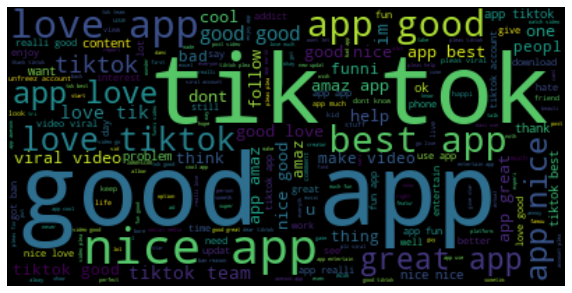

In [10]:
# checking most frequently used words
text = ' '.join(content for content in data.content)
# print(text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'black').generate(text)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

The above picture shows the most frequently used words, we can see that the word *"good", "best" ...* have been used to describe the app.

### **Sentiment analysis**

In the following code we are going to perform sentiment analysis, in order to categorize the review comments into various categories. To achieve this, we are going to use the *__Valence Aware Dictionary for sEntiment Reasoning, or Vader__*, is a NLP algorithm that blended a sentiment lexicon approach as well as grammatical rules and syntactical conventions for expressing sentiment polarity and intensity. Vader is an open-sourced package within the Natural Language Toolkit (NLTK).
*__An example of the Vader is shown in the picture below:__*
![](assets/vader.png)

In [11]:
# Trying to get the good and bad comments sorted
# nltk.download("vader_lexicon")
sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["content"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["content"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["content"]]
data = data[['content', 'Positive', 'Negative', 'Neutral']]
data.head()

C:\Users\arman\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arman\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\arman\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,content,Positive,Negative,Neutral
0,good,1.000,0.0,0.000
1,awesom app mani peopl easier fb girl awesom gu...,0.381,0.0,0.619
2,bad,0.000,1.0,0.000
3,good,1.000,0.0,0.000
4,interest app,0.750,0.0,0.250


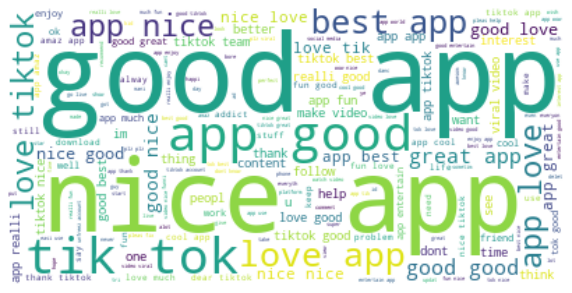

In [12]:
positive_comments = ' '.join([i for i in data['content'][data['Positive'] > data['Negative']]])
# print(positive_comments)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white').generate(positive_comments)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

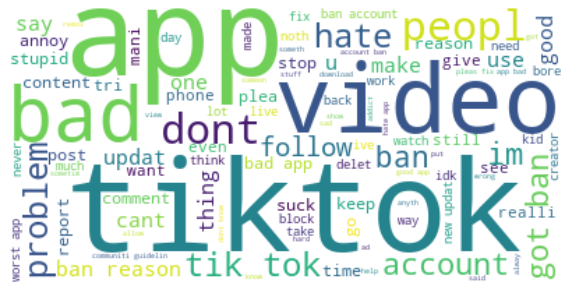

In [13]:
negative_comments = ' '.join([i for i in data['content'][data['Positive'] < data['Negative']]])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white', max_words = 100).generate(negative_comments)
plt.figure(figsize = (10,15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [14]:
from PIL import Image
import numpy as np

tiktok_mask = np.array(Image.open("./assets/tiktok.jpg"))
# tiktok_mask

In [15]:
def transform_pixel_value(pixel):
    if pixel == 0:
        return 255
    else:
        return pixel

new_tiktok_mask = np.ndarray((tiktok_mask.shape[0], tiktok_mask.shape[1]), np.int32)
# print(new_tiktok_mask)

# for i in range(len(tiktok_mask)):
#     new_tiktok_mask[i] = list(map(transform_pixel_value, tiktok_mask[i]))
    # new_tiktok_mask = map(transform_pixel_value, tiktok_mask[i])

# new_tiktok_mask

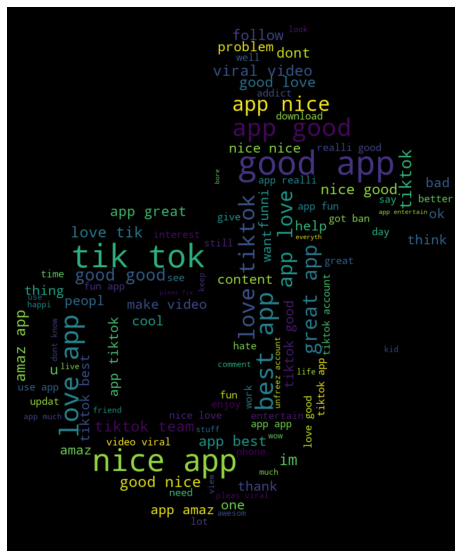

In [16]:
wc = WordCloud(stopwords = stopwords, max_words = 100, mask = tiktok_mask, contour_width = 3, contour_color = "black")
wc.generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Conclusion**
In this notebook, we analyzed what __TikTok__ users think of the app. We found good and bad comments and built a __wordcloud__
of comments.  